## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

The new_page and treatment don't match when the other combination are provided with each. Let's check the unique combination between group and landing_page

In [6]:
df.group.unique(), df.landing_page.unique()

(array(['control', 'treatment'], dtype=object),
 array(['old_page', 'new_page'], dtype=object))

There are two unique values which are control and treatment for groups and old_page and new_page for landing_page. Therefore, we need to find the number of rows where treatment was aligned with old_page and control was aligned with new page as follows:

In [7]:
treat_old=df.query("group=='treatment' and landing_page=='old_page'").shape[0]
control_new=df.query("group=='control' and landing_page=='new_page'").shape[0]
missmatch=treat_old+control_new
missmatch

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group == "control" and landing_page != "old_page")').index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated(keep=False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates()

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query("group=='control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query("group == 'treatment'").converted.mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The above results revealed some interesting facts about the data set. The overall conversion rate was about 11.95%, whereas the control group had an conversion rate of 12.04%, while the treatment group was lower conversion rates of 11.88%. This indicates that the new landing page is not leading to any improvement in terms of conversion rate.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?

**$H_{1}$: $p_{old}$ - $p_{new}$ <0**


**$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages respectively.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new=df2.converted.mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old=df2.converted.mean()
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted.mean()

0.11961241750452478

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted.mean()

0.12054462601704366

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.00093220851251887837

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs[:5]

[1.7648724993296616e-05,
 0.0015250783008375346,
 0.0011463711950774197,
 -0.00067753665719121059,
 0.00012109994661675672]

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

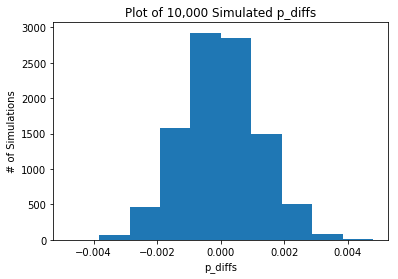

In [27]:
plt.hist(p_diffs);
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

At first, we need to convert p_diffs into a numpy array:

In [28]:
p_diffs=np.array(p_diffs)
p_diffs

array([  1.76487250e-05,   1.52507830e-03,   1.14637120e-03, ...,
         1.40112017e-03,  -8.42492830e-04,   3.83256012e-06])

Then, we need to compute the actual different observed:

In [29]:
act_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
act_diff

-0.0015790565976871451

In [30]:
(p_diffs > act_diff).mean()

0.9093

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We were calculating the p-value in part j which is the probability of getting our statistic or a more extreme value if the null is true. A small p-value (< 0.05) would suggest to reject the null-hypothesis, but we failed to reject the null-hypothesis as our p_value is higher (0.9058)**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3116075339133115, 0.90517370514059103)

Then,we import the norm function to compute the significance of our z-score.

In [33]:
from scipy.stats import norm
norm.cdf(z_score)

0.90517370514059103

Check our critical value at 95% confidence interval.

In [34]:
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Our z-score is:  1.3116075339133115 but in order to reject the null hypothesis, our z-score needs to exceed the level of:  1.959963984540054 
since this was not the case, we failed to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['ab_page2', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page2', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-12 12:28 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**From the above result, we would state that the conversion is not related to the page that was shown (new page) to the user. The alternative would suggest that there is a relation between the page showed (new page) to the user and the conversion.
Moreover,the p-value (0.1897)in the regression did not fall as well under the level of 0.05, we can argue that there is no relationship among the conversion of a user and the page that was shown to the user.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Allows for a more sophisticated model to distinguish other factors which may contribute to the outcome.
- May be used to identify outliers.
- May produce inaccurate results due to correlated errors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head(5)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [39]:
# Check number of unique rows under country column:
df_new.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [40]:
# sine there are three dummy variables, we will need to include two columns
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
945994,UK,2017-01-03 14:41:21.565258,control,old_page,0,1,0,1,0
945996,US,2017-01-09 18:58:19.952277,treatment,new_page,0,1,1,0,1
945997,US,2017-01-04 06:56:24.658147,control,old_page,0,1,0,0,1
945998,CA,2017-01-16 07:08:02.207969,control,old_page,0,1,0,0,0
945999,US,2017-01-16 04:56:21.132067,treatment,new_page,0,1,1,0,1


In [41]:
# the statistical output:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])

In [42]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-12 12:28 AIC:              212781.0880
No. Observations:   290585           BIC:              212812.8269
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5176  0.1291  -0.0119   0.0935
==================================================================

"""

*Based on the above result, the p-value for both countries has a value larger than 0.05; so, there is no statistical evidence on country's significant impact on conversion.*

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page']])

In [44]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-12 12:28 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2486  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5159  0.1296  -0.0119   0.0934
ab_page       -0.0150    0.0114   -1.3076  0.1910  -0.0374   0.0075
==================================================================

"""

As we can see from the results above, even after adding new column, there does not seem to be any statistical evidence to indicate an impact on the conversion since all p-values were greater than 0.05.

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0